In [1]:
import db_connection as db_conn
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count, avg, lag, unix_timestamp
from pyspark.sql.types import FloatType, ArrayType, IntegerType
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark import StorageLevel

import pandas as pd
import numpy as np
import math
from datetime import timedelta, datetime
from functools import reduce
import matplotlib.pyplot as plt


In [2]:
db_config = db_conn.config_sql
# Create a SparkSession
spark = SparkSession.builder \
    .appName("process_tx") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "32g") \
    .getOrCreate()

23/07/02 19:22:39 WARN Utils: Your hostname, NatRng-MBP.local resolves to a loopback address: 127.0.0.1; using 192.168.222.103 instead (on interface en0)
23/07/02 19:22:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/02 19:22:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
url = f"jdbc:mariadb://{db_config['host']}:{db_config['port']}/{db_config['database']}"
user = db_config['user']
password = db_config['password']
transactions_df = spark.read.format('jdbc').options(url=url, dbtable='Transactions', user=user, password=password).load()
block_df = spark.read.format('jdbc').options(url=url, dbtable='Blocks', user=user, password=password).load()
address_df = spark.read.format('jdbc').options(url=url, dbtable='Addresses', user=user, password=password).load()
category_df = spark.read.format('jdbc').options(url=url, dbtable='TxCategories', user=user, password=password).load()
contract_df = spark.read.format('jdbc').options(url=url, dbtable='Contracts', user=user, password=password).load()

Outgoing and incoming Transactions

In [4]:
outgoing_transactions = transactions_df.groupby("from_id")\
                             .agg(F.count("tx_id").alias("outgoing_tx_count"))

incoming_transactions = transactions_df.filter(col("to_id").isNotNull()).groupby("to_id")\
                             .agg(F.count("tx_id").alias("incoming_tx_count"))

outgoing_transactions = outgoing_transactions.withColumnRenamed("from_id", "address_id")
incoming_transactions = incoming_transactions.withColumnRenamed("to_id", "address_id")

transactions_count = outgoing_transactions.join(incoming_transactions, "address_id", "outer")
transactions_count = transactions_count.fillna(0)

Time diff between first and last transaction

In [5]:
outgoing_timestamps = address_df.join(transactions_df, address_df.address_id == transactions_df.from_id, "left").select("address_id", "timestamp")
outgoing_timestamps = outgoing_timestamps.na.drop(subset=["timestamp"])
incoming_timestamps = address_df.join(transactions_df, address_df.address_id == transactions_df.to_id, "left").select("address_id", "timestamp")
incoming_timestamps = incoming_timestamps.na.drop(subset=["timestamp"])

all_timestamps = outgoing_timestamps.union(incoming_timestamps)
# Group by address_id and calculate min, max timestamp
transactions_timestamps = all_timestamps.groupBy("address_id")\
                                          .agg(F.min("timestamp").alias("first_tx_timestamp"),
                                               F.max("timestamp").alias("last_tx_timestamp"))

# Calculate the time difference for each address_id in minutes
transactions_timestamps = transactions_timestamps.withColumn(
    "time_difference",
    F.col("last_tx_timestamp").cast("long") - F.col("first_tx_timestamp").cast("long"))

transactions_timestamps = transactions_timestamps.withColumn(
    "time_difference_in_minutes",
    (F.col("time_difference") / 60))

# Show the results
transactions_timestamps = transactions_timestamps.select("address_id", "time_difference_in_minutes")

In [6]:
windowSpec = Window.partitionBy("address_id").orderBy("timestamp")
time_diff_secs = (unix_timestamp(col("timestamp")) - lag(unix_timestamp(col("timestamp"))).over(windowSpec))

outtx_subquery = outgoing_timestamps.withColumn("time_diff_secs", time_diff_secs) \
    .groupBy("address_id") \
    .agg(avg(col("time_diff_secs")).alias("avg_time_diff_secs"))

# Calculate the average time difference in minutes by dividing by 60
avg_outgoing_tx = outtx_subquery.withColumn("avg_time_diff_out_minutes", col("avg_time_diff_secs") / 60) \
    .select("address_id", "avg_time_diff_out_minutes")

inctx_subquery = incoming_timestamps.withColumn("time_diff_secs", time_diff_secs) \
    .groupBy("address_id") \
    .agg(avg(col("time_diff_secs")).alias("avg_time_diff_secs"))

# Calculate the average time difference in minutes by dividing by 60
avg_incoming_tx = inctx_subquery.withColumn("avg_time_diff_in_minutes", col("avg_time_diff_secs") / 60) \
    .select("address_id", "avg_time_diff_in_minutes")

all_tx_subquery = all_timestamps.withColumn("time_diff_secs", time_diff_secs) \
    .groupBy("address_id") \
    .agg(avg(col("time_diff_secs")).alias("avg_time_diff_secs"))

avg_total_tx = all_tx_subquery.withColumn("total_avg_time_diff_minutes", col("avg_time_diff_secs") / 60) \
    .select("address_id", "total_avg_time_diff_minutes")

avg_tx = avg_outgoing_tx.join(avg_incoming_tx, "address_id", "outer")
avg_tx = avg_tx.join(avg_total_tx, "address_id", "outer")
avg_tx = avg_tx.fillna(0)
                                                            

Contract Creation

In [7]:
contracts_created  = contract_df.join(transactions_df, contract_df['tx_id'] == transactions_df['tx_id'], "left")\
                                .select(contract_df["contract_id"], contract_df["tx_id"], transactions_df["from_id"])

contracts_created = contracts_created.groupBy("from_id").agg(F.count("tx_id").alias("contracts_created"))
contracts_created = contracts_created.withColumnRenamed("from_id", "address_id")

Get Unique Received From Addresses

In [8]:
unique_received_transactions = transactions_df.filter(col("to_id").isNotNull()).groupBy("to_id").agg(F.countDistinct("from_id").alias("unique_received_transactions"))
unique_received_transactions = unique_received_transactions.withColumnRenamed("to_id", "address_id")
unique_sent_transactions = transactions_df.groupBy("from_id").agg(F.countDistinct("to_id").alias("unique_sent_transactions"))
unique_sent_transactions = unique_sent_transactions.withColumnRenamed("from_id", "address_id")

In [9]:
incoming_eth = transactions_df.filter(col("asset") == "ETH").filter(col("to_id").isNotNull()) \
                    .fillna({"asset_value": 0}) \
                    .groupBy("to_id").agg(F.sum("asset_value").alias("total_incoming_eth"))
incoming_eth = incoming_eth.withColumnRenamed("to_id", "address_id")

outgoing_eth = transactions_df.filter(col("asset") == "ETH")\
                    .fillna({"asset_value": 0}) \
                    .groupBy("from_id").agg(F.sum("asset_value").alias("total_outgoing_eth"))
outgoing_eth = outgoing_eth.withColumnRenamed("from_id", "address_id")

erc20 transfers

In [10]:
#cast erc_20_tnx asset_value to float
erc_20_tnx = transactions_df.filter(col("category_id") == 3)
erc_20_tnx = erc_20_tnx.withColumn("asset_value", erc_20_tnx["asset_value"].cast(FloatType()))
outgoing_erc_20_tnx = erc_20_tnx.groupBy("from_id").agg(F.count("tx_id").alias("outgoing_erc_20_tnx"))
incoming_erc_20_tnx = erc_20_tnx.filter(col("to_id").isNotNull()).groupBy("to_id").agg(F.count("tx_id").alias("incoming_erc_20_tnx"))
outgoing_erc_20_tnx = outgoing_erc_20_tnx.withColumnRenamed("from_id", "address_id")
incoming_erc_20_tnx = incoming_erc_20_tnx.withColumnRenamed("to_id", "address_id")
total_erc_20_tnx = outgoing_erc_20_tnx.join(incoming_erc_20_tnx, "address_id", "outer").fillna(0)
total_erc_20_tnx = total_erc_20_tnx.withColumn("total_erc_20_tnx", F.col("outgoing_erc_20_tnx") + F.col("incoming_erc_20_tnx"))
total_erc_20_tnx = total_erc_20_tnx.select("address_id", "outgoing_erc_20_tnx", "incoming_erc_20_tnx", "total_erc_20_tnx")

ERC 20 ETH TX Features

In [11]:
erc20eth_out = erc_20_tnx.filter(col("asset") == "ETH")\
                .fillna({"asset_value": 0}) \
                .groupBy("from_id").agg(F.sum("asset_value").alias("total_outgoing_erc20eth"))
erc20eth_out = erc20eth_out.withColumnRenamed("from_id", "address_id")

erc20eth_in = erc_20_tnx.filter(col("asset") == "ETH")\
                .filter(col("to_id").isNotNull()) \
                .fillna({"asset_value": 0}) \
                .groupBy("to_id").agg(F.sum("asset_value").alias("total_incoming_erc20eth"))
erc20eth_in = erc20eth_in.withColumnRenamed("to_id", "address_id")

min_erc20token_out = erc_20_tnx.groupBy("from_id") \
                    .min("asset_value").withColumnRenamed("min(asset_value)", "min_erc20token_out")
min_erc20token_out = min_erc20token_out.withColumnRenamed("from_id", "address_id")

min_erc20token_in = erc_20_tnx.filter(col("to_id").isNotNull()).groupBy("to_id") \
                    .min("asset_value").withColumnRenamed("min(asset_value)", "min_erc20token_in")
min_erc20token_in = min_erc20token_in.withColumnRenamed("to_id", "address_id")

max_erc20token_out = erc_20_tnx.groupBy("from_id") \
                    .max("asset_value").withColumnRenamed("max(asset_value)", "max_erc20token_out")
max_erc20token_out = max_erc20token_out.withColumnRenamed("from_id", "address_id")

max_erc20token_in = erc_20_tnx.filter(col("to_id").isNotNull()).groupBy("to_id") \
                    .max("asset_value").withColumnRenamed("max(asset_value)", "max_erc20token_in")
max_erc20token_in = max_erc20token_in.withColumnRenamed("to_id", "address_id")

num_unique_erc20tokens_out = erc_20_tnx.groupBy("from_id") \
                            .agg(F.countDistinct("asset").alias("num_unique_erc20tokens_out"))
num_unique_erc20tokens_out = num_unique_erc20tokens_out.withColumnRenamed("from_id", "address_id")

num_unique_erc20tokens_in = erc_20_tnx.filter(col("to_id").isNotNull()).groupBy("to_id") \
                            .agg(F.countDistinct("asset").alias("num_unique_erc20tokens_in"))
num_unique_erc20tokens_in = num_unique_erc20tokens_in.withColumnRenamed("to_id", "address_id")

ERC1155 Transactions Features

In [12]:
#cast erc_20_tnx asset_value to float
erc_1155_tnx = transactions_df.filter(col("category_id") == 1)
outgoing_erc_1155_tnx = erc_1155_tnx.groupBy("from_id").agg(F.count("tx_id").alias("outgoing_erc_1155_tnx"))
incoming_erc_1155_tnx = erc_1155_tnx.filter(col("to_id").isNotNull()).groupBy("to_id").agg(F.count("tx_id").alias("incoming_erc_1155_tnx"))
outgoing_erc_1155_tnx = outgoing_erc_1155_tnx.withColumnRenamed("from_id", "address_id")
incoming_erc_1155_tnx = incoming_erc_1155_tnx.withColumnRenamed("to_id", "address_id")
total_erc_1155_tnx = outgoing_erc_1155_tnx.join(incoming_erc_1155_tnx, "address_id", "outer").fillna(0)
total_erc_1155_tnx = total_erc_1155_tnx.withColumn("total_erc_1155_tnx", F.col("outgoing_erc_1155_tnx") + F.col("incoming_erc_1155_tnx"))
total_erc_1155_tnx = total_erc_1155_tnx.select("address_id", "outgoing_erc_1155_tnx", "incoming_erc_1155_tnx", "total_erc_1155_tnx")

ERC721 TX Features

In [13]:
erc_721_tnx = transactions_df.filter(col("category_id") == 5)
outgoing_erc_721_tnx = erc_721_tnx.groupBy("from_id").agg(F.count("tx_id").alias("outgoing_erc_721_tnx"))
incoming_erc_721_tnx = erc_721_tnx.filter(col("to_id").isNotNull()).groupBy("to_id").agg(F.count("tx_id").alias("incoming_erc_721_tnx"))
outgoing_erc_721_tnx = outgoing_erc_721_tnx.withColumnRenamed("from_id", "address_id")
incoming_erc_721_tnx = incoming_erc_721_tnx.withColumnRenamed("to_id", "address_id")
total_erc_721_tnx = outgoing_erc_721_tnx.join(incoming_erc_721_tnx, "address_id", "outer").fillna(0)
total_erc_721_tnx = total_erc_721_tnx.withColumn("total_erc_721_tnx", F.col("outgoing_erc_721_tnx") + F.col("incoming_erc_721_tnx"))
total_erc_721_tnx = total_erc_721_tnx.select("address_id", "outgoing_erc_721_tnx", "incoming_erc_721_tnx", "total_erc_721_tnx")

num_unique_erc721asset_out = erc_721_tnx.groupBy("from_id") \
                            .agg(F.countDistinct("asset").alias("num_unique_erc721asset_out"))
num_unique_erc721asset_out = num_unique_erc721asset_out.withColumnRenamed("from_id", "address_id")

num_unique_erc721asset_in = erc_721_tnx.filter(col("to_id").isNotNull()).groupBy("to_id") \
                            .agg(F.countDistinct("asset").alias("num_unique_erc721asset_in"))
num_unique_erc721asset_in = num_unique_erc721asset_in.withColumnRenamed("to_id", "address_id")

num_unique_erc721token_out = erc_721_tnx.groupBy("from_id") \
                            .agg(F.countDistinct("erc721_token_id").alias("num_unique_erc721tokens_out"))
num_unique_erc721token_out = num_unique_erc721token_out.withColumnRenamed("from_id", "address_id")

num_unique_erc721token_in = erc_721_tnx.filter(col("to_id").isNotNull()).groupBy("to_id") \
                            .agg(F.countDistinct("erc721_token_id").alias("num_unique_erc721tokens_in"))
num_unique_erc721tokent_in = num_unique_erc721token_in.withColumnRenamed("to_id", "address_id")

Compute Gini Coefficients of daily and monthly transactions

In [14]:
transactions_df = transactions_df.withColumn('date', F.to_date('timestamp', 'yyyy-MM-dd HH:mm:ss'))
transactions_df = transactions_df.withColumn('week_of_year', F.weekofyear('date'))

In [15]:
# Aggregate tx_id counts by day for each from_id and collect as list
daily_from_transactions = transactions_df.groupBy('from_id', 'date').agg(F.count('tx_id').alias('daily_tx_count'))
daily_from_transactions = daily_from_transactions.groupBy('from_id').agg(F.collect_list('daily_tx_count').alias('daily_tx_counts'))

# Aggregate tx_id counts by day for each to_id and collect as list
daily_to_transactions = transactions_df.filter(col("to_id").isNotNull()).groupBy('to_id', 'date').agg(F.count('tx_id').alias('daily_tx_count'))
daily_to_transactions = daily_to_transactions.groupBy('to_id').agg(F.collect_list('daily_tx_count').alias('daily_tx_counts'))
# Aggregate tx_id counts by week for each from_id and collect as list
weekly_from_transactions = transactions_df.groupBy('from_id', 'week_of_year').agg(F.count('tx_id').alias('weekly_tx_count'))
weekly_from_transactions = weekly_from_transactions.groupBy('from_id').agg(F.collect_list('weekly_tx_count').alias('weekly_tx_counts'))

# Aggregate tx_id counts by week for each to_id and collect as list
weekly_to_transactions = transactions_df.filter(col("to_id").isNotNull()).groupBy('to_id', 'week_of_year').agg(F.count('tx_id').alias('weekly_tx_count'))
weekly_to_transactions = weekly_to_transactions.groupBy('to_id').agg(F.collect_list('weekly_tx_count').alias('weekly_tx_counts'))


In [16]:
total_transactions_out = transactions_df.select("from_id", "timestamp", "date", "week_of_year")
total_transactions_in = transactions_df.filter(col("to_id").isNotNull()).select("to_id", "timestamp", "date", "week_of_year")
total_transactions_out = total_transactions_out.withColumnRenamed("from_id", "address_id")
total_transactions_in = total_transactions_in.withColumnRenamed("to_id", "address_id")
total_transactions = total_transactions_out.union(total_transactions_in)

daily_total_transactions = total_transactions.groupBy("address_id", "date").agg(F.count("timestamp").alias("daily_total_tx_count"))
daily_total_transactions = daily_total_transactions.groupBy("address_id").agg(F.collect_list("daily_total_tx_count").alias("daily_total_tx_counts"))

weekly_total_transactions = total_transactions.groupBy("address_id", "week_of_year").agg(F.count("timestamp").alias("weekly_total_tx_count"))
weekly_total_transactions = weekly_total_transactions.groupBy("address_id").agg(F.collect_list("weekly_total_tx_count").alias("weekly_total_tx_counts"))


In [17]:
# Define your UDF
def extend_day_list(input_list):
    if len(input_list) < 30:
        input_list += [0] * (30 - len(input_list))
    return input_list

def extend_week_list(input_list):
    if len(input_list) < 4:
        input_list += [0] * (4 - len(input_list))
    return input_list

# Now we need to register this function as a UDF with spark
udf_extend_day_list = F.udf(extend_day_list, ArrayType(IntegerType()))
udf_extend_week_list = F.udf(extend_week_list, ArrayType(IntegerType()))

daily_from_transactions = daily_from_transactions.withColumn("daily_tx_counts", udf_extend_day_list(daily_from_transactions['daily_tx_counts']))
daily_to_transactions = daily_to_transactions.withColumn("daily_tx_counts", udf_extend_day_list(daily_to_transactions['daily_tx_counts']))

weekly_from_transactions = weekly_from_transactions.withColumn("weekly_tx_counts", udf_extend_week_list(weekly_from_transactions['weekly_tx_counts']))
weekly_to_transactions = weekly_to_transactions.withColumn("weekly_tx_counts", udf_extend_week_list(weekly_to_transactions['weekly_tx_counts']))

daily_total_transactions = daily_total_transactions.withColumn("daily_total_tx_counts", udf_extend_day_list(daily_total_transactions['daily_total_tx_counts']))
weekly_total_transactions = weekly_total_transactions.withColumn("weekly_total_tx_counts", udf_extend_week_list(weekly_total_transactions['weekly_total_tx_counts']))

In [18]:
def calculate_gini_idx(x):
    x = sorted(x)  # sort the list
    n = len(x)
    total = sum((i+1) * xi for i, xi in enumerate(x))
    gini_index = (2 * total) / (n * sum(x)) - (n + 1) / n
    return gini_index

udf_calculate_gini_idx = F.udf(calculate_gini_idx, FloatType())

daily_from_transactions = daily_from_transactions.withColumn('daily_from_gini_index', udf_calculate_gini_idx('daily_tx_counts'))
daily_to_transactions = daily_to_transactions.withColumn('daily_to_gini_index', udf_calculate_gini_idx('daily_tx_counts'))

weekly_from_transactions = weekly_from_transactions.withColumn('weekly_from_gini_index', udf_calculate_gini_idx('weekly_tx_counts'))
weekly_to_transactions = weekly_to_transactions.withColumn('weekly_to_gini_index', udf_calculate_gini_idx('weekly_tx_counts'))

daily_total_transactions = daily_total_transactions.withColumn('daily_total_gini_index', udf_calculate_gini_idx('daily_total_tx_counts'))
weekly_total_transactions = weekly_total_transactions.withColumn('weekly_total_gini_index', udf_calculate_gini_idx('weekly_total_tx_counts'))

# Rename the id columns before joining
daily_from_transactions = daily_from_transactions.withColumnRenamed("from_id", "address_id")
daily_to_transactions = daily_to_transactions.withColumnRenamed("to_id", "address_id")
weekly_from_transactions = weekly_from_transactions.withColumnRenamed("from_id", "address_id")
weekly_to_transactions = weekly_to_transactions.withColumnRenamed("to_id", "address_id")

# Prepare the list of all dataframes to join
gini_dfs = [daily_from_transactions, daily_to_transactions, weekly_from_transactions, 
       weekly_to_transactions, daily_total_transactions, weekly_total_transactions]

daily_gini_index = reduce(lambda a, b: a.join(b, "address_id", "outer"), gini_dfs[0:2])
daily_gini_index = daily_gini_index.select("address_id", "daily_from_gini_index", "daily_to_gini_index")
 
weekly_gini_index = reduce(lambda a, b: a.join(b, "address_id", "outer"), gini_dfs[2:4])
weekly_gini_index = weekly_gini_index.select("address_id", "weekly_from_gini_index", "weekly_to_gini_index")

total_gini_index = reduce(lambda a, b: a.join(b, "address_id", "outer"), gini_dfs[4:6])
total_gini_index = total_gini_index.select("address_id", "daily_total_gini_index", "weekly_total_gini_index")


In [19]:
daily_gini_index.write.mode('overwrite').parquet("data/parquet_files/daily_gini_idx.parquet")
weekly_gini_index.write.mode('overwrite').parquet("data/parquet_files/weekly_gini_idx.parquet")
total_gini_index.write.mode('overwrite').parquet("data/parquet_files/total_gini_idx.parquet")

Recency Transactions

In [20]:
gamma = 0.3
window_period = Window.partitionBy("address_id").orderBy("timestamp")

def compute_recency(time_delta):
    if time_delta is None:
        tx_recency = 0
    else:
        tx_recency = math.exp(-gamma * time_delta)
    return tx_recency

udf_tx_recency = F.udf(compute_recency, FloatType())

outgoing_tx_times = address_df.join(transactions_df, address_df.address_id == transactions_df.from_id, "left").select("tx_id", "address_id", "timestamp")
incoming_tx_times = address_df.join(transactions_df, address_df.address_id == transactions_df.to_id, "left").select("tx_id", "address_id", "timestamp")

# Calculate the time difference in days
time_diff_days = (unix_timestamp(col("timestamp")) - lag(unix_timestamp(col("timestamp"))).over(window_period)) / 86400

# Apply the time difference and compute recency function to the outgoing transactions
outgoing_tx_times = outgoing_tx_times.withColumn("time_diff_days", time_diff_days)
outgoing_tx_times = outgoing_tx_times.withColumn("recency", udf_tx_recency(col("time_diff_days")))
outgoing_tx_times = outgoing_tx_times.fillna({"recency": 0})
outgoing_tx_times = outgoing_tx_times.select("tx_id", "address_id", "timestamp", "time_diff_days", "recency")
outgoing_recency_avg = outgoing_tx_times.groupBy("address_id").agg(F.median('recency').alias("median_recency_out"))

# Apply the time difference and compute recency function to the incoming transactions
incoming_tx_times = incoming_tx_times.withColumn("time_diff_days", time_diff_days)
incoming_tx_times = incoming_tx_times.withColumn("recency", udf_tx_recency(col("time_diff_days")))
incoming_tx_times = incoming_tx_times.fillna({"recency": 0})
incoming_tx_times = incoming_tx_times.select("tx_id", "address_id", "timestamp","time_diff_days", "recency")
incoming_recency_avg = incoming_tx_times.groupBy("address_id").agg(F.median('recency').alias("median_recency_in"))


# Join the two dataframes
recency_avg = outgoing_recency_avg.join(incoming_recency_avg, "address_id", "outer")
recency_avg = recency_avg.fillna(0)
recency_avg = recency_avg.select("address_id", "median_recency_out", "median_recency_in")

In [ ]:
outgoing_tx_times.write.mode('overwrite').parquet("data/parquet_files/outgoing_tx_times_train.parquet")

EDA for recency metric

In [ ]:
out_tx_df = pd.read_parquet("data/parquet_files/outgoing_tx_times_train.parquet")
# Drop rows with null values in "time_diff_days" column
out_tx_df = out_tx_df.dropna(subset=['time_diff_days'])
grouped_out_tx_df = out_tx_df.groupby('address_id')['time_diff_days'].agg(list).reset_index()

In [ ]:
#select rows with recency above 0.1 and less than 0.9
recency_df = out_tx_df[(out_tx_df['recency'] > 0.1) & (out_tx_df['recency'] < 0.9)] 
recency_df

,tx_id,address_id,timestamp,time_diff_days,recency
4,30398382.0,28,2022-05-04 04:10:03,2.043507,0.541695
6,62416924.0,28,2022-05-04 20:16:11,0.670926,0.817685
20,28981524.0,28,2022-05-06 09:41:35,1.435417,0.650103
48,16297456.0,28,2022-05-08 11:15:53,2.065486,0.538135
84,30769846.0,28,2022-05-09 10:54:33,0.582940,0.839556
...,...,...,...,...,...
58034960,45524364.0,7201918,2022-05-26 22:03:30,6.919016,0.125468
58034988,42097284.0,7203021,2022-05-14 12:45:00,5.129167,0.214649
58035304,10708884.0,7213363,2022-05-22 03:34:52,2.464213,0.477465
58035424,33834711.0,7217031,2022-05-07 16:53:28,2.391377,0.488013


In [ ]:
grouped_out_tx_df['skewness'] = grouped_out_tx_df['time_diff_days'].apply(lambda x: pd.Series(x).skew())
skewness_symmetrical = grouped_out_tx_df[(grouped_out_tx_df['skewness'] < 0.5) & (grouped_out_tx_df['skewness'] > -0.5)]
skewness_asymmetrical = grouped_out_tx_df[(grouped_out_tx_df['skewness'] >= 0.5) | (grouped_out_tx_df['skewness'] <= -0.5)]

Check For Skewness

In [ ]:
print("Number of addresses with symmetrical skewness: ", len(skewness_symmetrical))
print("Number of addresses with asymmetrical skewness: ", len(skewness_asymmetrical))

Number of addresses with symmetrical skewness:  70151
Number of addresses with asymmetrical skewness:  1116531


Gamma decay value selection

In [ ]:
grouped_out_tx_df['median'] = grouped_out_tx_df['time_diff_days'].apply(lambda x: pd.Series(x).median())

/var/folders/xs/x2x4yg29089c8t_v4z9nymz40000gn/T/ipykernel_15452/2256060580.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_out_tx_df['median'] = grouped_out_tx_df['time_diff_days'].apply(lambda x: pd.Series(x).median())


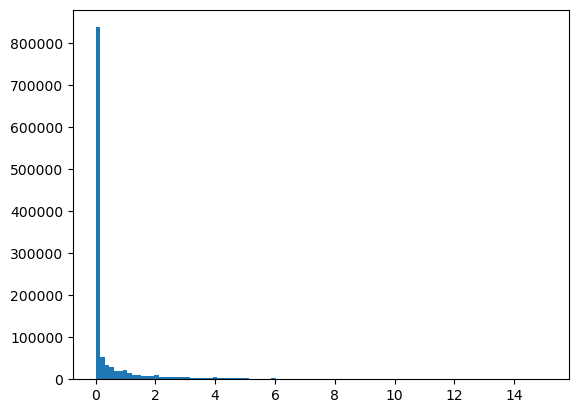

In [ ]:
#plot histogram of median
plt.hist(grouped_out_tx_df['median'], bins=100)
plt.show()

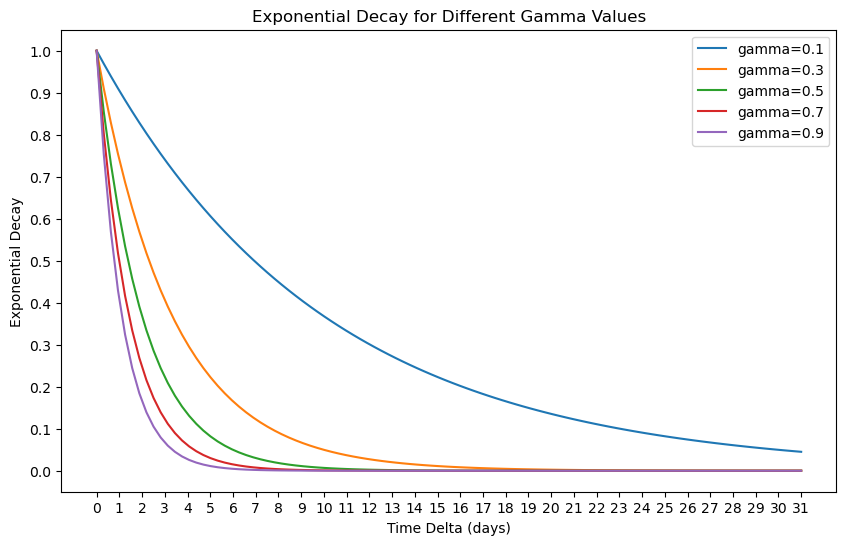

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

time_delta = np.linspace(0, 31, 100)
gammas = [0.1, 0.3, 0.5, 0.7, 0.9]  # different gamma values

# Create a new figure with a specified size
plt.figure(figsize=(10, 6))  # You can adjust the size as needed

# Plot the exponential decay for each gamma
for gamma in gammas:
    decay = np.exp(-gamma * time_delta)
    plt.plot(time_delta, decay, label=f'gamma={gamma}')

plt.title('Exponential Decay for Different Gamma Values')
plt.xlabel('Time Delta (days)')
plt.ylabel('Exponential Decay')

# Set x and y ticks
plt.xticks(np.arange(0, max(time_delta)+1, 1))
plt.yticks(np.arange(0, 1.1, 0.1))  # assuming the max decay value to be 1

plt.legend()
plt.show()


In [21]:
recency_avg.write.mode('overwrite').parquet("data/parquet_files/recency_avg.parquet")

In [ ]:
recency_test = pd.read_parquet("data/parquet_files/recency_avg.parquet")
print(len(recency_test))

7224385


Anomolous ETH transactions

In [22]:
median_k = 1.4826
# Compute the median of the incoming Ethereum transactions
incoming_median = transactions_df.filter(col("asset") == "ETH") \
    .filter(col("to_id").isNotNull()) \
    .fillna({"asset_value": 0}) \
    .groupBy("to_id") \
    .agg(F.median('asset_value').alias("median_eth_in"))

outgoing_median = transactions_df.filter(col("asset") == "ETH") \
    .fillna({"asset_value": 0}) \
    .groupBy("from_id") \
    .agg(F.median('asset_value').alias("median_eth_out"))

# Alias the original DataFrame
transactions_df_alias = transactions_df.alias("transactions_df")

# Join the original DataFrame with the one containing the medians
incoming_joined = transactions_df_alias.filter(col("asset") == "ETH") \
    .filter(col("to_id").isNotNull()) \
    .fillna({"asset_value": 0}) \
    .join(incoming_median, transactions_df_alias.to_id == incoming_median.to_id, 'inner')

# Compute the absolute deviations from the median
incoming_devs = incoming_joined.withColumn("abs_dev", median_k*F.abs(incoming_joined.asset_value - incoming_joined.median_eth_in))

# Compute the median of these absolute deviations
incoming_mad = incoming_devs.groupBy("transactions_df.to_id") \
    .agg(F.median('abs_dev').alias("mad_eth_in"))

# Follow similar process for outgoing transactions
outgoing_joined = transactions_df_alias.filter(col("asset") == "ETH") \
    .fillna({"asset_value": 0}) \
    .join(outgoing_median, transactions_df_alias.from_id == outgoing_median.from_id, 'inner')

outgoing_devs = outgoing_joined.withColumn("abs_dev", median_k*F.abs(outgoing_joined.asset_value - outgoing_joined.median_eth_out))

outgoing_mad = outgoing_devs.groupBy("transactions_df.from_id") \
    .agg(F.median('abs_dev').alias("mad_eth_out"))

# Join the two DataFrames and join with median DataFrame
outgoing_median_mad = outgoing_median.join(outgoing_mad, "from_id")
outgoing_median_mad = outgoing_median_mad.withColumnRenamed("from_id", "address_id")
outgoing_median_mad = outgoing_median_mad.alias("outgoing_median_mad")

incoming_median_mad = incoming_median.join(incoming_mad, "to_id")
incoming_median_mad = incoming_median_mad.withColumnRenamed("to_id", "address_id")
incoming_median_mad = incoming_median_mad.alias("incoming_median_mad")

In [23]:
def compute_zscore(value, median, mad):
    return F.when(mad != 0, (value - median) / mad).otherwise(0)

transfer_df_expanded = transactions_df.filter(col("asset") == "ETH")\
                        .join(outgoing_median_mad, transactions_df.from_id == outgoing_median_mad.address_id, "left")
transfer_df_expanded = transfer_df_expanded.join(incoming_median_mad, transfer_df_expanded.to_id == incoming_median_mad.address_id, "left")\
                        .fillna({"median_eth_out": 0, "mad_eth_out": 0, "median_eth_in": 0, "mad_eth_in": 0})
# Define a function to calculate the z-score

# Apply the function to the "asset_value_in" and "asset_value_out" columns
transfer_df_expanded = transfer_df_expanded.withColumn("zscore_eth_in", 
                                   compute_zscore(F.col("asset_value"), 
                                                  F.col("median_eth_in"), 
                                                  F.col("mad_eth_in")))

transfer_df_expanded = transfer_df_expanded.withColumn("zscore_eth_out", 
                                   compute_zscore(F.col("asset_value"), 
                                                  F.col("median_eth_out"), 
                                                  F.col("mad_eth_out")))

In [24]:
outgoing_outliers = transfer_df_expanded.groupBy("from_id")\
    .agg(F.sum(F.when((F.col("zscore_eth_out") > 3.5) | (F.col("zscore_eth_out") < -3.5), 1).otherwise(0))\
    .alias("num_outliers_eth_out"))
outgoing_outliers = outgoing_outliers.withColumnRenamed("from_id", "address_id")

incoming_outliers = transfer_df_expanded.groupBy("to_id")\
    .agg(F.sum(F.when((F.col("zscore_eth_in") > 3.5) | (F.col("zscore_eth_in") < -3.5), 1).otherwise(0))\
    .alias("num_outliers_eth_in"))
incoming_outliers = incoming_outliers.withColumnRenamed("to_id", "address_id")

In [25]:
merged_outliers = outgoing_outliers.join(incoming_outliers, "address_id", "outer").fillna(0)

In [26]:
merged_outliers.write.mode('overwrite').parquet("data/parquet_files/outliers.parquet")
# transfer_df_expanded.select("tx_id", "from_id", "to_id", "timestamp", "asset_value", "zscore_eth_in", "zscore_eth_out").write.mode('overwrite').parquet("data/parquet_files/transfer_df.parquet")

In [ ]:
zscores_df = spark.read.parquet("data/parquet_files/transfer_df_train.parquet")
zscores_df = zscores_df.fillna({"zscore_eth_in": 0, "zscore_eth_out": 0})
# Convert the DataFrame columns to lists
zscore_eth_in_list = zscores_df.select("zscore_eth_in").rdd.flatMap(lambda x: x).collect()
zscore_eth_out_list = zscores_df.select("zscore_eth_out").rdd.flatMap(lambda x: x).collect()

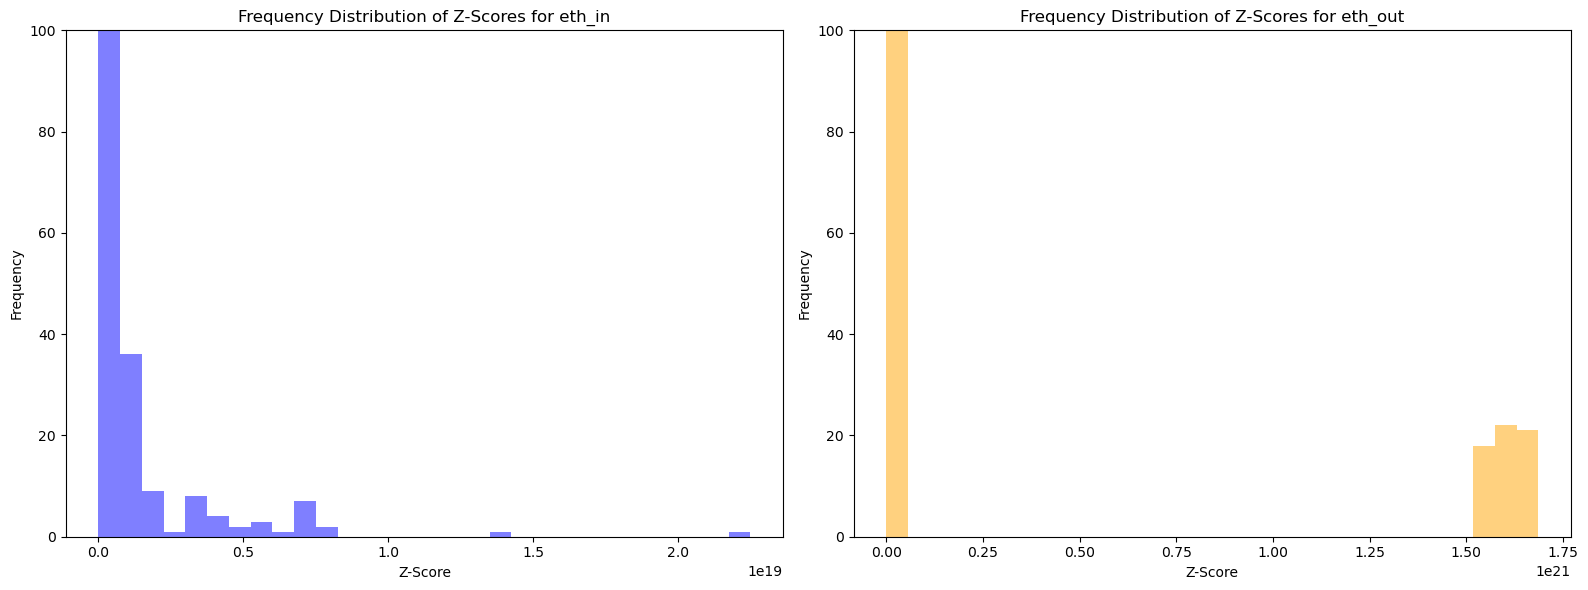

In [ ]:
# Create a figure with 2 subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot the histogram for zscore_eth_in in the first subplot
axs[0].hist(zscore_eth_in_list, bins=30, alpha=0.5, color='blue')
axs[0].set_xlabel('Z-Score')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Frequency Distribution of Z-Scores for eth_in')
axs[0].set_ylim([0, 100]) 

# Plot the histogram for zscore_eth_out in the second subplot
axs[1].hist(zscore_eth_out_list, bins=30, alpha=0.5, color='orange')
axs[1].set_xlabel('Z-Score')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Frequency Distribution of Z-Scores for eth_out')
axs[1].set_ylim([0, 100])

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
#count number of transactions with zscore above 3.5 or below -3.5
outliers_out = [zscore for zscore in zscore_eth_out_list if zscore > 3.5 or zscore < -3.5]
outliers_in = [zscore for zscore in zscore_eth_in_list if zscore > 3.5 or zscore < -3.5]

In [ ]:
print("Total number of transactions: ", len(zscore_eth_out_list))
print("Number of outliers for eth_out: ", len(outliers_out))
print("Number of outliers for eth_in: ", len(outliers_in))

Total number of transactions:  31080408
Number of outliers for eth_out:  2819213
Number of outliers for eth_in:  2747765


Merge DFs

In [ ]:
dfs_1 = [transactions_count, transactions_timestamps, contracts_created, avg_tx, unique_received_transactions, unique_sent_transactions, 
         incoming_eth, outgoing_eth, total_erc_20_tnx, erc20eth_out, erc20eth_in, min_erc20token_in, min_erc20token_out]
account_data_1 = reduce(lambda a, b: a.join(b, "address_id", "outer"), dfs_1)
account_data_1 = account_data_1.repartition(100)
account_data_1.write.mode('overwrite').parquet("data/parquet_files/account_data_1_train.parquet")
account_data_1 = None

In [ ]:
dfs_2 = [max_erc20token_in, max_erc20token_out, num_unique_erc20tokens_out, num_unique_erc20tokens_in, 
         total_erc_1155_tnx, total_erc_721_tnx, num_unique_erc721asset_out, num_unique_erc721asset_in]
account_data_2 = reduce(lambda a, b: a.join(b, "address_id", "outer"), dfs_2)
account_data_2.write.mode('overwrite').parquet("data/parquet_files/account_data_2_train.parquet")
account_data_2 = None

In [28]:
fillna_values = {
    "outgoing_tx_count": 0, "incoming_tx_count": 0, "time_difference_in_minutes": 0, "contracts_created": 0,
    "avg_time_diff_out_minutes": 0, "avg_time_diff_in_minutes": 0, "total_avg_time_diff_minutes": 0,
    "unique_received_transactions": 0, "unique_sent_transactions": 0, "total_incoming_eth": 0,
    "total_outgoing_eth": 0, "outgoing_erc_20_tnx": 0, "incoming_erc_20_tnx": 0, "total_erc_20_tnx": 0,
    "total_outgoing_erc20eth": 0, "total_incoming_erc20eth": 0, "min_erc20token_in": 0,
    "min_erc20token_out": 0, "max_erc20token_in": 0, "max_erc20token_out": 0,
    "num_unique_erc20tokens_out": 0, "num_unique_erc20tokens_in": 0, "outgoing_erc_1155_tnx": 0,
    "incoming_erc_1155_tnx": 0, "total_erc_1155_tnx": 0, "outgoing_erc_721_tnx": 0,
    "incoming_erc_721_tnx": 0, "total_erc_721_tnx": 0, "num_unique_erc721asset_out": 0,
    "num_unique_erc721asset_in": 0
}

account_data_1 = spark.read.parquet("data/parquet_files/account_data_1.parquet")
account_data_2 = spark.read.parquet("data/parquet_files/account_data_2.parquet")
daily_gini_index = spark.read.parquet("data/parquet_files/daily_gini_idx.parquet")
weekly_gini_index = spark.read.parquet("data/parquet_files/weekly_gini_idx.parquet")
total_gini_index = spark.read.parquet("data/parquet_files/total_gini_idx.parquet")
recency_avg = spark.read.parquet("data/parquet_files/recency_avg.parquet")
outliers = spark.read.parquet("data/parquet_files/outliers.parquet")
merge_saved_df = [account_data_1, account_data_2, daily_gini_index, weekly_gini_index, total_gini_index, recency_avg, outliers]
account_df = reduce(lambda a, b: a.join(b, "address_id", "outer"), merge_saved_df)
account_df = account_df.fillna(fillna_values)

account_df = account_df.withColumn("total_tx_with_contracts", 
                                   F.col("outgoing_tx_count") + F.col("incoming_tx_count") + F.col("contracts_created"))

account_df = account_df.select([
    "address_id", "outgoing_tx_count", "incoming_tx_count", "unique_received_transactions", "unique_sent_transactions",
    "contracts_created", "total_tx_with_contracts", "total_incoming_eth", "total_outgoing_eth", "time_difference_in_minutes",
    "avg_time_diff_out_minutes", "avg_time_diff_in_minutes", "total_avg_time_diff_minutes", "outgoing_erc_20_tnx",
    "incoming_erc_20_tnx", "total_erc_20_tnx", "total_outgoing_erc20eth", "total_incoming_erc20eth", "min_erc20token_in",
    "min_erc20token_out", "max_erc20token_in", "max_erc20token_out", "num_unique_erc20tokens_out",
    "num_unique_erc20tokens_in", "outgoing_erc_1155_tnx", "incoming_erc_1155_tnx", "total_erc_1155_tnx",
    "outgoing_erc_721_tnx", "incoming_erc_721_tnx", "total_erc_721_tnx", "num_unique_erc721asset_out",
    "num_unique_erc721asset_in", "daily_from_gini_index", "daily_to_gini_index", "weekly_from_gini_index",
    "weekly_to_gini_index", "daily_total_gini_index", "weekly_total_gini_index", "median_recency_out", "median_recency_in",
    "num_outliers_eth_out", "num_outliers_eth_in"
])

account_df = account_df.filter(col("daily_total_gini_index").isNotNull())

In [35]:
#count null values in each column
account_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in account_df.columns]).show()

+----------+-----------------+-----------------+----------------------------+------------------------+-----------------+-----------------------+------------------+------------------+--------------------------+-------------------------+------------------------+---------------------------+-------------------+-------------------+----------------+-----------------------+-----------------------+-----------------+------------------+-----------------+------------------+--------------------------+-------------------------+---------------------+---------------------+------------------+--------------------+--------------------+-----------------+--------------------------+-------------------------+---------------------+-------------------+----------------------+--------------------+----------------------+-----------------------+------------------+-----------------+--------------------+-------------------+
|address_id|outgoing_tx_count|incoming_tx_count|unique_received_transactions|unique_sent_tra

In [29]:
account_df.write.mode('overwrite').parquet("data/parquet_files/account_df.parquet")

23/07/02 19:45:53 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [30]:
account_df = spark.read.parquet("data/parquet_files/account_df.parquet")
account_df.orderBy(F.asc('weekly_total_gini_index')).show()

+----------+-----------------+-----------------+----------------------------+------------------------+-----------------+-----------------------+--------------------+-------------------+--------------------------+-------------------------+------------------------+---------------------------+-------------------+-------------------+----------------+-----------------------+-----------------------+-----------------+------------------+-----------------+------------------+--------------------------+-------------------------+---------------------+---------------------+------------------+--------------------+--------------------+-----------------+--------------------------+-------------------------+---------------------+-------------------+----------------------+--------------------+----------------------+-----------------------+--------------------+--------------------+--------------------+-------------------+
|address_id|outgoing_tx_count|incoming_tx_count|unique_received_transactions|unique_

23/07/02 20:17:31 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 302158 ms exceeds timeout 120000 ms
23/07/02 20:17:31 WARN SparkContext: Killing executors is not supported by current scheduler.
23/07/02 20:17:37 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at sc